In [2]:
import pandas as pd
import numpy as np
from zoneinfo import ZoneInfo
import warnings
warnings.filterwarnings('ignore')

# 1 Functions

In [3]:
#=======================================================================
# = Find consecutive missing data
# = Note that missing data at midnight has been filled up with zero
# = In one day, there might be multiple consective missing data vector
# = In the present instance, we simply set a threshold value
# = If the consective missing number lareger than the threshold value
# = the PV sites will be discarded for further algorithm development.
# =======================================================================
def consecutive_missdata(df):
    # return: [[index_start, nannumb], [index_start, nannumb], ...]
    nagroup_df5min = df.notna().cumsum()[df.isna()]
    lengths_consecutive_na = nagroup_df5min.groupby(nagroup_df5min).agg(len)
    indexlist = lengths_consecutive_na.index.values
    valuelist = lengths_consecutive_na.values
    missdata_dic = []
    for j in range(len(lengths_consecutive_na)):

        # only one continuous missing data
        if j == 0:
            nanindex_start = indexlist[0]
            nannum = valuelist[0]
        else:
            nanindex_start = indexlist[j] + np.sum(valuelist[0:j])
            nannum = valuelist[j]
        missdata_dic.append([nanindex_start, nannum])
    return missdata_dic

In [4]:
#=================================================================
# = Function for processing consective missing data
# ================================================================
def process_consecutive_missdata(df, missdata_list, thred, fillmethod):
    df.set_index('time', inplace=True)
    max_consecutivenan = np.max(np.array(missdata_list)[:, 1])
    # print('max_consecutivenan:', max_consecutivenan)
    if max_consecutivenan > thred:
        return None
    else:
        if fillmethod == 'linear':
            df = df.interpolate().values
        elif fillmethod == 'time':
            df = df.interpolate(method='time').values
        elif fillmethod == 'nearest':
            df = df.interpolate(method='nearest').values
        elif fillmethod == 'ffill': # Replace NaN with preceding values
            df.fillna(method=fillmethod, inplace=True)
        elif fillmethod == 'bfill': # Replace NaN with backward values
            df.fillna(method=fillmethod, inplace=True)
        else:
            RecursionError('Please check the fill method')
        return df

In [5]:
#=================================================================
# = Function for preprocessing missing data: including three steps
# ================================================================
def preprocess_data(df, MIDP, thred, fillmethod, pvsize):
    # Step 1. replace outlier (larger than pvsize) with nan
    df['hour'] = df['time'].dt.hour
    nightlist = [20, 21, 22, 23, 0, 1, 2, 3, 4, 5]

    df_outlier_idx = df[df[MIDP].astype(float) > 1.1*pvsize]
    df.iloc[df_outlier_idx.index.to_list(), 1] = np.nan

    # Step 2. fill up missing data at midnight with zero  # need to be checked
    df[df['hour'].isin(nightlist)] = df[df['hour'].isin(nightlist)].fillna(0)
    # Step 3. find the consecutive missing data, for example there are half an hour missing data with 5-minute resolution
    # Check if there is missing data
    if df[MIDP].isna().sum() >0:
        # find consecutive missing data
        missdata_list = consecutive_missdata(df[MIDP])
        df = df.drop('hour', axis=1)
        df = process_consecutive_missdata(df=df, missdata_list=missdata_list,thred=thred, fillmethod=fillmethod)
    return df


In [6]:
#=================================================================
# = Preprocess a monitor with steps in details
# ================================================================
def preprocess_single_monitor(MID, df, df_att, thred, fillmethod):
    if MID in df.columns.to_list():
        pvsize = df_att.loc[df_att['source']==MID, 'pvSizeWatt'].values[0]
        df_pv = preprocess_data(df=df[['time', MID]], MIDP=MID, thred=thred, fillmethod=fillmethod, pvsize=pvsize)
        if df_pv is None:
            df.drop(MID, axis=1, inplace=True)
        else:
            df_pv = np.maximum(df_pv, 0)
            df[MID] = df_pv
    else:
        print('there is no such PV systems:', MID)

    return df

# 2 Parameter settings

In [7]:
# set focus pv systems and time periods
local_tz = 'Australia/Sydney'
local_tzzi = ZoneInfo(local_tz)
# time_start/end is UTC time, migh cause missing data when convert to local timezone
time_start = '2022-11-11'
time_end = '2022-11-18'
measure_name = 'Gen.W'
# parameters for preprocessing missing data
fillmethod = 'nearest' # preprocess missing data
thred5min = 600 # 5 hour for 5-minute data
thred15min = 20 # 5 hour for 15-minute data


# 3 Prepare Data

## 3.1. Select data for a specific time period for preprocessing

In [ ]:
# ================== 1. find the pv system covers the time periods for the algorithm ==================
df_lasttime = pd.read_csv('../preprocessed_data/daily_last_time_20231016.csv', header=0)
# check if the recorded data covers the time period: time_start_short & time_end_short
df_lasttime = df_lasttime[(df_lasttime['time_start']!='None') & (df_lasttime['time_end'] != 'None')]
# filter data available pv systems
df_filter = df_lasttime[(df_lasttime['time_start']<time_start) & (df_lasttime['time_end']>time_end) & (df_lasttime['time_resolution']==5)]
# find the pv list
pvlist = df_filter['source'].values.tolist()
# df_filter

In [ ]:
# ============== 2. combine recorded data list with their attributions, such as latitude/longitude/timezone ==========
# table with timezone
df_SITE = pd.read_csv('../input_data/SITE_nodeType_20230630.csv', header=0) 
# table with latitude & longitude
df_MNTR = pd.read_csv('../input_data/MNTR_ddb_20230630.csv', header=0)
df_MNTR['timezone'] = df_MNTR['siteId'].map(df_SITE.set_index('source')['timezone'])
df_MNTR['latitude'] = [x[1:] for x in df_MNTR['latitude']]
# combine attribute with the recorded pv systems in one table
att_list = ['timezone', 'latitude', 'longitude', 'tilt', 'azimuth', 'loss', 'pvSizeWatt']
for att in att_list: 
    df_filter[att] = df_filter['source'].map(df_MNTR.set_index('source')[att])
    if att != 'timezone':
        df_MNTR[att] = df_MNTR[att].astype(str)
        df_MNTR[att] = df_MNTR[att].str.strip("'")
        df_MNTR[att] = df_MNTR[att].astype(float)
df_filter['latitude'] = [x[1:] for x in df_filter['latitude']]
# df_filter

## 3.2. Read Monitor Data

In [10]:
# =============== 3. read data of different pv systems & identify its time resolution ===============
df_5min = pd.read_csv('../preprocessed_data/5min_rawdata_20231016.csv')

In [11]:
df_5min_concern = df_5min[['time'] + pvlist]
df_5min_concern

,time,MNTR|a6e623b2-105d-47c5-a0e9-aa5e006a9faf,MNTR|BOPQ-75B2-AIOH-HTPZ,MNTR|6204060,MNTR|1046505_1_1_1,MNTR|22179934,MNTR|b827eb83f07e,MNTR|6056768,MNTR|79ee7c8c-c2c5-4f33-b0da-65140cd57239,MNTR|22181898,...,MNTR|828237,MNTR|23119233,MNTR|KYU7-KLSN-XP6F-SOI9,MNTR|1114095,MNTR|22131936,MNTR|2157470,MNTR|2306020,MNTR|2262148,MNTR|1052799_1_1_1,MNTR|5556047
0,2019-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-01 00:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-01 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-01 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-01 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508316,2023-10-31 23:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
508317,2023-10-31 23:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
508318,2023-10-31 23:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
508319,2023-10-31 23:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 4 Preprocessing Data

## 4.1 Process Outliers and Missing Data

In [12]:
# ======================= 3 Process outliers and missing data ===============

pvlist_before_preprocess = pvlist
print('PV number before preprocessing missing data:', len(pvlist_before_preprocess))
df_5min_preprocess = df_5min_concern.copy()
df_5min_preprocess['time'] = pd.to_datetime(df_5min_preprocess['time'])
for i, MID in enumerate(pvlist_before_preprocess):
    df_5min_preprocess = preprocess_single_monitor(MID=MID, df=df_5min_preprocess, df_att=df_MNTR, thred=thred5min, fillmethod=fillmethod)

df_5min_preprocess.fillna(0, inplace=True)

print('PV number after preprocessing missing data:', len(df_5min_preprocess.columns.to_list())-1)
df_5min_preprocess.head()

PV number before preprocessing missing data: 62
PV number after preprocessing missing data: 62


,time,MNTR|a6e623b2-105d-47c5-a0e9-aa5e006a9faf,MNTR|BOPQ-75B2-AIOH-HTPZ,MNTR|6204060,MNTR|1046505_1_1_1,MNTR|22179934,MNTR|b827eb83f07e,MNTR|6056768,MNTR|79ee7c8c-c2c5-4f33-b0da-65140cd57239,MNTR|22181898,...,MNTR|828237,MNTR|23119233,MNTR|KYU7-KLSN-XP6F-SOI9,MNTR|1114095,MNTR|22131936,MNTR|2157470,MNTR|2306020,MNTR|2262148,MNTR|1052799_1_1_1,MNTR|5556047
0,2019-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-01-01 00:05:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-01-01 00:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-01-01 00:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


305928 502506


<Axes: xlabel='time'>

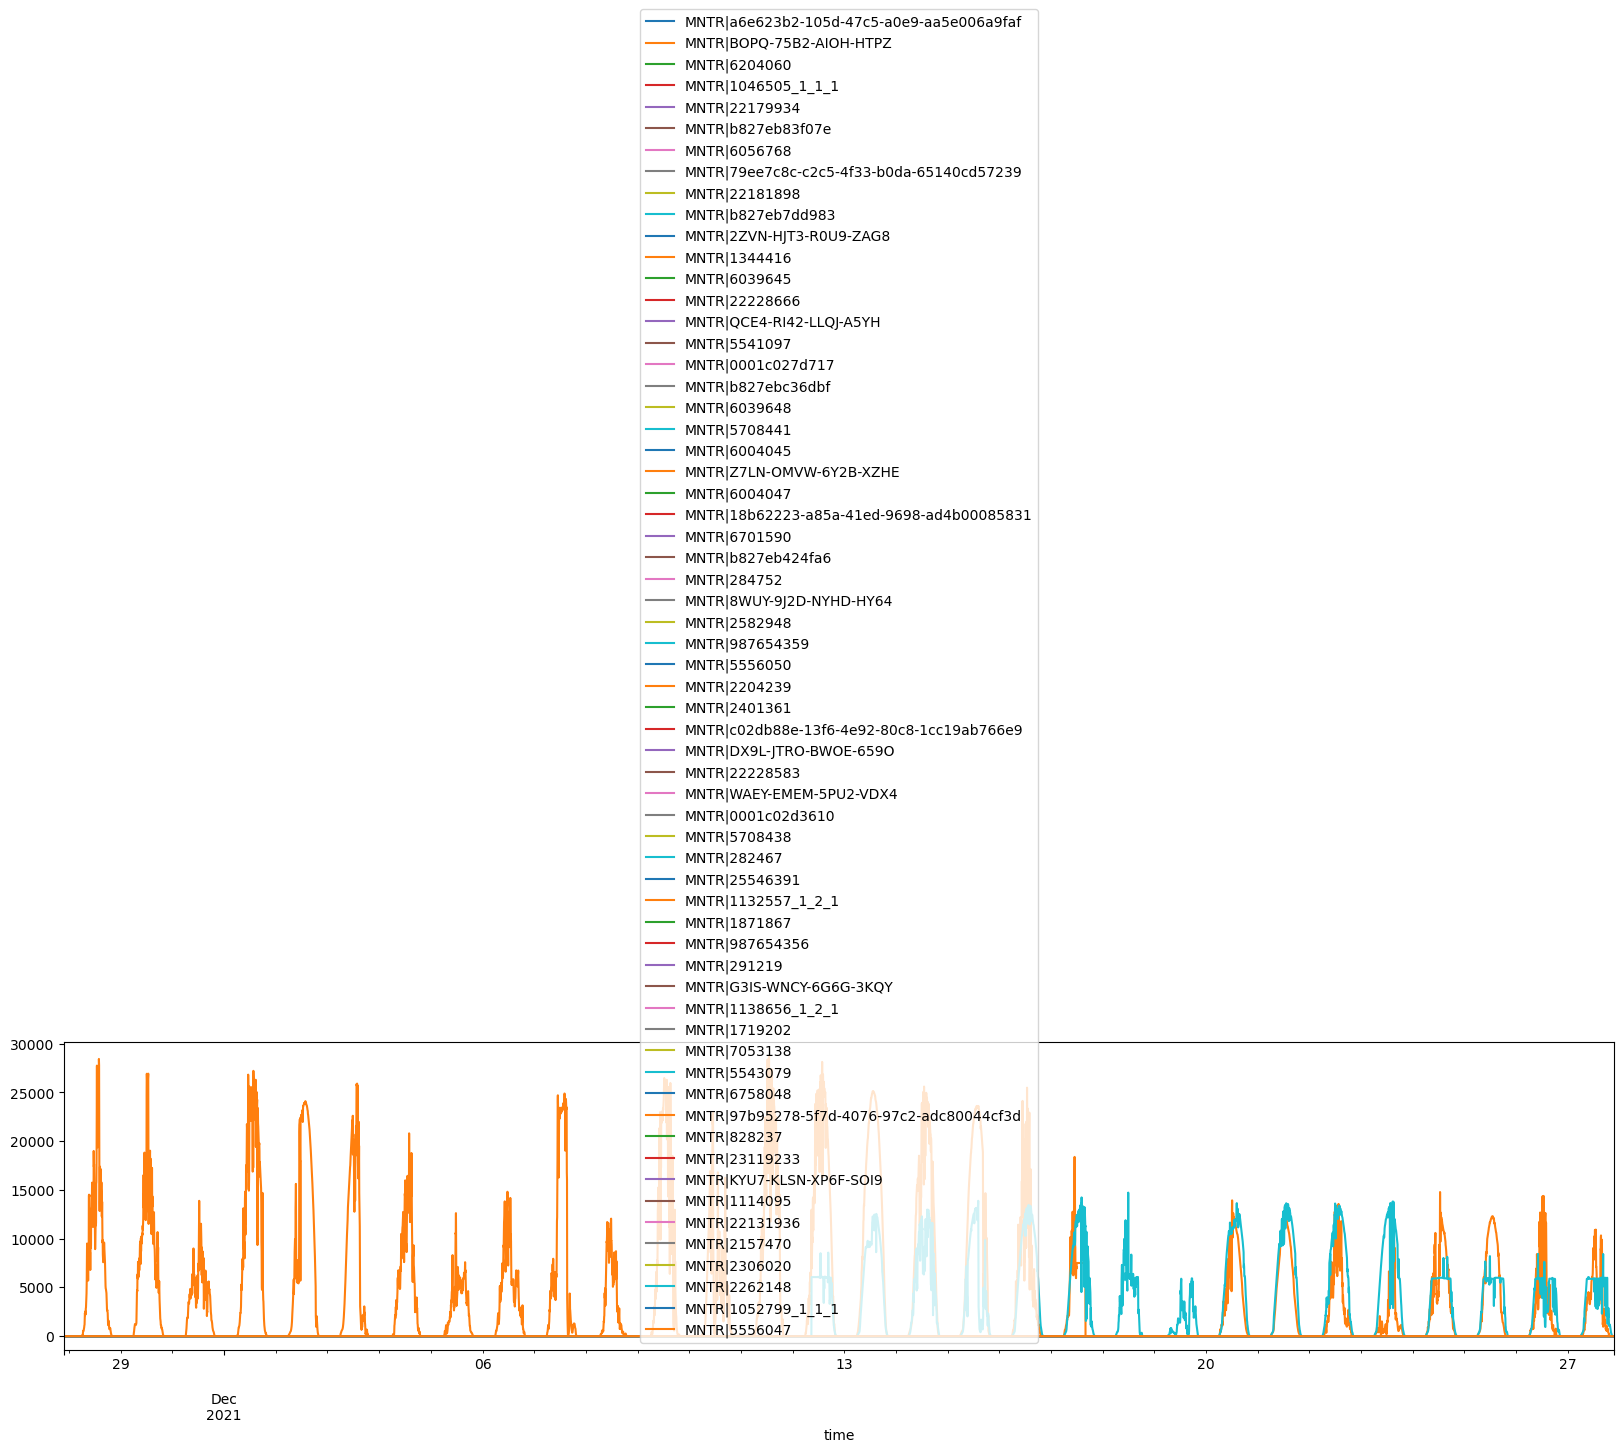

In [13]:
def find_nonzero_indices(df, column_to_check):
    # Find the index of the first nonzero value across all columns
    first_nonzero_index = (df[column_to_check] != 0).idxmax().min()
    last_nonzero_index = (df[column_to_check][::-1] != 0).idxmax().max()
    return first_nonzero_index, last_nonzero_index

first_nonzero_index, last_nonzero_index = find_nonzero_indices(df=df_5min_preprocess, column_to_check=df_5min_preprocess.columns.to_list()[1:])
print(first_nonzero_index, last_nonzero_index)

df_5min_preprocess = df_5min_preprocess.iloc[max(first_nonzero_index-100, 0):max(last_nonzero_index+100, len(df_5min_preprocess)), :]
df_5min_preprocess.index = np.arange(len(df_5min_preprocess))
df_5min_preprocess.iloc[0:30*288, :].set_index('time').plot(figsize=(20, 4))

## 4.2 Check the Time Zone 

In [18]:
# ======================= 4 double check the time zone is correct for 5-minute PV system =
df_5min_check = df_5min_preprocess.copy()
df_5min_check.reset_index(inplace=True)
df_5min_check['hour'] = df_5min_check['time'].dt.hour
df_5min_check = df_5min_check[(df_5min_check['hour']==4) | (df_5min_check['hour']==23)]
df_5min_check.set_index('time', inplace=True)

remove_col_list = [x for x in df_5min_check.columns.to_list() if not x.startswith('MNTR')]
df_5min_check.drop(remove_col_list, axis=1, inplace=True)
df_5min_check = df_5min_check[df_5min_check>100]
df_5min_check.dropna(how='all', axis='columns', inplace=True)
mids_double_check = df_5min_check.columns.to_list()
print(mids_double_check)
print('total pv sites with wrong time zone:', len(mids_double_check))

['MNTR|6204060', 'MNTR|5541097', 'MNTR|6004045', 'MNTR|6004047', 'MNTR|2401361', 'MNTR|c02db88e-13f6-4e92-80c8-1cc19ab766e9', 'MNTR|2157470', 'MNTR|2306020']
total pv sites with wrong time zone: 8


<Axes: xlabel='time'>

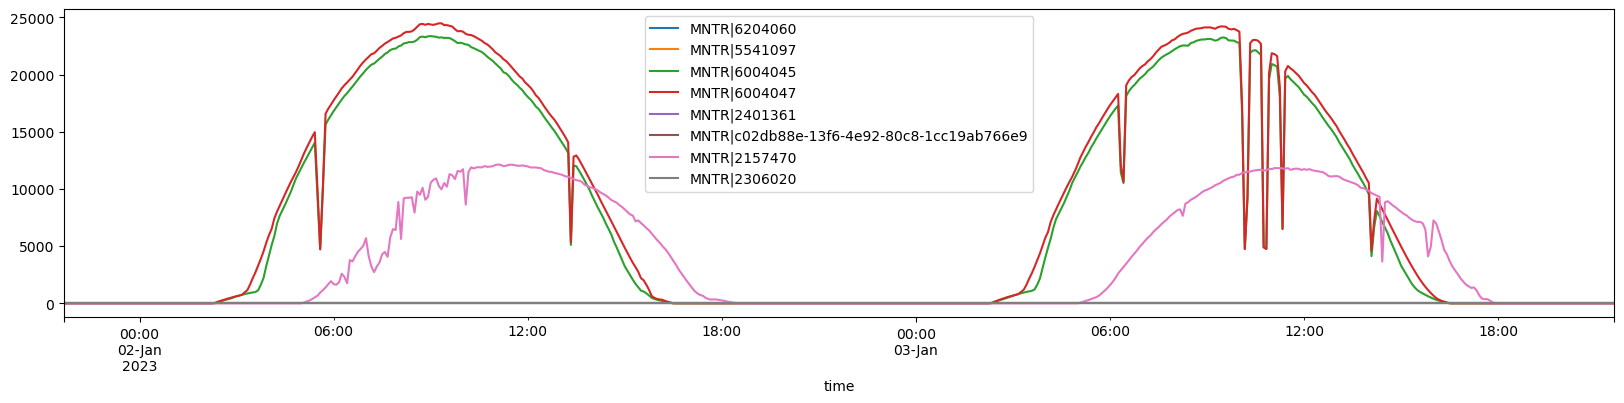

In [28]:
df_5min_preprocess[['time']+mids_double_check].iloc[400*288:402*288, :].set_index('time').plot(figsize=(20, 4))